In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression, ElasticNet

import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from pymer4.models import Lmer
from scipy import stats
import itertools
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [7]:
mdat = pd.read_csv('../data/MFQAnalysesDatabaseforDylan.csv', index_col=0).reset_index(drop=True)
mdat['Clinical_Visit_Date'] = pd.to_datetime(mdat.Clinical_Visit_Date)
mdat['PreviousVisitDate'] = pd.to_datetime(mdat.PreviousVisitDate)
mdat = mdat.loc[mdat.TimeBetween<800].reset_index(drop=True)


In [16]:
unraveled = []
for ss, sdf in mdat.groupby('SDAN'):
    sdf = sdf.sort_values('Clinical_Visit_Date').reset_index(drop=True)
    bsl_dat = {}
    bsl_dat['SDAN'] = ss
    bsl_dat['Participant_Type2'] = sdf.Participant_Type2.unique()[0]
    bsl_dat['Clinical_Visit_Date'] = sdf.loc[0, 'PreviousVisitDate']
    bsl_dat['s_mfq_tot'] = sdf.loc[0, 'MFQtminus1']
    bsl_dat['antidepressants'] = sdf.loc[0, 'antidepressants']
    bsl_dat['OtherMeds'] = sdf.loc[0, 'OtherMeds']
    bsl_dat['InpatientDuring'] = sdf.loc[0, 'InpatientDuring']
    bsl_dat['postpandemic'] = sdf.loc[0, 'postpandemic']
    bsl_dat['Age_at_visit'] = sdf.loc[0, 'PreviousAge']
    bsl_dat['SEX'] = sdf.loc[0, 'SEX']
    bsl_dat['dep_immed'] = sdf.dep_immed.unique()[0]
    bsl_dat = pd.DataFrame(bsl_dat, index=[0])
    sdf = pd.concat((bsl_dat, sdf)).loc[:, sdf.columns]
    sdf['bsl_date'] = bsl_dat.Clinical_Visit_Date.values[0]
    sdf['visit_ix'] = range(len(sdf))
    unraveled.append(sdf)
udat = pd.concat(unraveled).reset_index(drop=True)

In [17]:
udat['time_since_bsl'] = ((udat.Clinical_Visit_Date - udat.bsl_date).dt.days)/365.25

In [19]:
model = 's_mfq_tot ~ dep_immed*time_since_bsl + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (time_since_bsl | SDAN) + (1|visit_ix)'
lmer = Lmer(model, udat)
lmer.fit()


Formula: s_mfq_tot~dep_immed*time_since_bsl+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(time_since_bsl|SDAN)+(1|visit_ix)

Family: gaussian	 Inference: parametric

Number of observations: 1439	 Groups: {'SDAN': 129.0, 'visit_ix': 40.0}

Log-likelihood: -4264.029 	 AIC: 8528.057

Random effects:

                    Name     Var    Std
SDAN         (Intercept)  35.559  5.963
SDAN      time_since_bsl   9.049  3.008
visit_ix     (Intercept)   0.609  0.780
Residual                  15.375  3.921

              IV1             IV2   Corr
SDAN  (Intercept)  time_since_bsl -0.641

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.432,1.074,19.789,4.774,122.457,2.185,0.031,*
dep_immed,1.163,-1.370,3.696,1.292,118.422,0.900,0.370,
time_since_bsl,0.002,-1.458,1.461,0.745,146.973,0.002,0.998,
InpatientDuringTRUE,1.138,0.003,2.273,0.579,1214.325,1.965,0.050,*
Age_at_visit,0.018,-0.576,0.612,0.303,117.631,0.058,0.954,
SEXMALE,-3.598,-5.590,-1.606,1.016,106.612,-3.540,0.001,***
antidepressants,0.099,-1.905,2.103,1.023,107.004,0.097,0.923,
OtherMeds,0.606,-1.630,2.842,1.141,104.672,0.531,0.597,
postpandemicTRUE,-0.135,-1.054,0.784,0.469,1323.259,-0.288,0.774,
dep_immed:time_since_bsl,-0.261,-1.718,1.196,0.743,92.442,-0.351,0.726,


In [54]:
model = 's_mfq_tot ~ time_since_bsl + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (time_since_bsl | SDAN) + (1|visit_ix)'
lmer = Lmer(model, udat)
lmer.fit()


Formula: s_mfq_tot~time_since_bsl+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(time_since_bsl|SDAN)+(1|visit_ix)

Family: gaussian	 Inference: parametric

Number of observations: 1439	 Groups: {'SDAN': 129.0, 'visit_ix': 40.0}

Log-likelihood: -4266.015 	 AIC: 8532.031

Random effects:

                    Name     Var    Std
SDAN         (Intercept)  35.534  5.961
SDAN      time_since_bsl   8.939  2.990
visit_ix     (Intercept)   0.603  0.777
Residual                  15.380  3.922

              IV1             IV2   Corr
SDAN  (Intercept)  time_since_bsl -0.643

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.785,1.556,20.014,4.709,119.168,2.290,0.024,*
time_since_bsl,-0.245,-1.264,0.773,0.520,220.670,-0.472,0.637,
InpatientDuringTRUE,1.133,-0.000,2.266,0.578,1212.301,1.960,0.050,.
Age_at_visit,0.051,-0.536,0.637,0.299,117.264,0.169,0.866,
SEXMALE,-3.674,-5.657,-1.691,1.012,107.651,-3.632,0.000,***
antidepressants,0.142,-1.856,2.141,1.020,107.710,0.140,0.889,
OtherMeds,0.603,-1.628,2.834,1.138,105.329,0.530,0.597,
postpandemicTRUE,-0.113,-1.030,0.805,0.468,1323.077,-0.241,0.810,


In [55]:
sub_level_estimates = lmer.fixef[0].reset_index().rename(columns={'index':'SDAN'})
sub_level_estimates['SDAN'] = sub_level_estimates.SDAN.astype(int)
sub_level_estimates = sub_level_estimates.merge(udat.groupby('SDAN').dep_immed.first(), how='left', on='SDAN', suffixes=('_beta', ''))

<AxesSubplot:xlabel='time_since_bsl', ylabel='Count'>

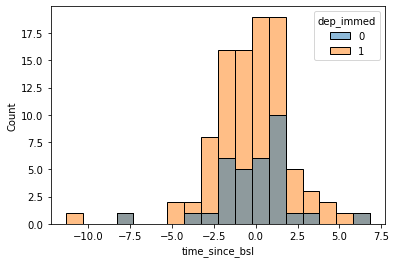

In [56]:
sns.histplot(data=sub_level_estimates, x='time_since_bsl', hue='dep_immed')

In [61]:
nofhd = sub_level_estimates.loc[sub_level_estimates.dep_immed == 0, 'time_since_bsl'].values
fhd = sub_level_estimates.loc[sub_level_estimates.dep_immed == 1, 'time_since_bsl'].values
stats.ttest_ind(nofhd, fhd, equal_var=False)

Ttest_indResult(statistic=0.48161357856920084, pvalue=0.6319516643204219)

In [62]:
len(sub_level_estimates)

129

In [58]:
sub_level_estimates['traj_class'] = 'flat'
sub_level_estimates.loc[sub_level_estimates.time_since_bsl < -0.5, 'traj_class'] = 'improving'
sub_level_estimates.loc[sub_level_estimates.time_since_bsl > 0.5, 'traj_class'] = 'worsening'

In [59]:
nofhd_traj_counts = sub_level_estimates.loc[sub_level_estimates.dep_immed == 0,:].groupby(['traj_class']).SDAN.count().values
nofhd_traj_freqs = nofhd_traj_counts/ nofhd_traj_counts.sum()
fhd_traj_counts = sub_level_estimates.loc[sub_level_estimates.dep_immed == 1,:].groupby(['traj_class']).SDAN.count().values
fhd_traj_freqs = fhd_traj_counts / fhd_traj_counts.sum()

In [60]:
stats.chisquare(nofhd_traj_freqs, fhd_traj_freqs)

Power_divergenceResult(statistic=0.03842836074241033, pvalue=0.9809692353861094)

In [50]:
nofhd_traj

array([ 7, 12, 14])